In [26]:
# Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

# Importing the data
df_credit = pd.read_csv("./data/german_credit_data.csv", index_col=0)

## Preprocessing

In [27]:
# set age category
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)


df_good = df_credit[df_credit["Risk"] == 'good']
df_bad = df_credit[df_credit["Risk"] == 'bad']

df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

# Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
# Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [28]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [14]:
print(pd.crosstab(df_credit["Checking account"],df_credit.Sex))

Sex               female  male
Checking account              
little                88   186
moderate              86   183
rich                  20    43


In [29]:
# Excluding unused columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
# del df_credit["Sex"]
del df_credit["Housing"]
# del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']

In [30]:
# Transform string to integer
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])
df_credit['Sex'].replace('female', 0,inplace=True)
df_credit['Sex'].replace('male', 1, inplace=True)
df_credit['Age_cat'].replace('Student', 1,inplace=True)
df_credit['Age_cat'].replace('Young', 2, inplace=True)
df_credit['Age_cat'].replace('Adult', 3, inplace=True)
df_credit['Age_cat'].replace('Senior', 4, inplace=True)

In [83]:
def get_training_result(df, advanced = True):
    #Creating the X and y variables
    X = df.drop('Risk_bad', 1).values
    y = df["Risk_bad"].values

    # Spliting X and y into train and test version
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.36, random_state=42)

    from sklearn.utils import resample
    from sklearn.metrics import roc_curve
    # Criando o classificador logreg
    GNB = GaussianNB()

    # Fitting with train data
    model = GNB.fit(X_train, y_train)

    print("Accuracy: ", model.score(X_train, y_train))

    y_pred = model.predict(X_test)

    print("\n")
    print("Confusion matrix: ")

    print(confusion_matrix(y_test, y_pred))
    print("\n")
    print(classification_report(y_test, y_pred))

    #Predicting proba
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print("ROC_AUC: ", roc_auc_score(y_test, y_pred_prob))
    
    if advanced:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        print("\n")
        print("Group fairness: ", (tp + fp) / (tp + fp + tn + fn))
        print("Separation with FPR: ", fp / (fp + tn))

Accuracy:  0.696875


Confusion matrix: 
[[172  78]
 [ 49  61]]


              precision    recall  f1-score   support

           0       0.78      0.69      0.73       250
           1       0.44      0.55      0.49       110

    accuracy                           0.65       360
   macro avg       0.61      0.62      0.61       360
weighted avg       0.67      0.65      0.66       360



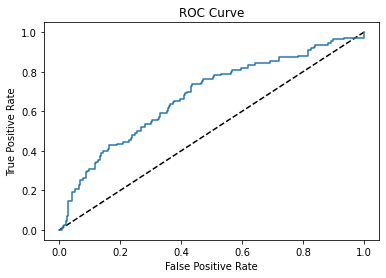

ROC_AUC:  0.6771636363636364


In [84]:
get_training_result(df_credit, False)

# Anti-classificaion

## Sex

Accuracy:  0.7


Confusion matrix: 
[[171  79]
 [ 49  61]]


              precision    recall  f1-score   support

           0       0.78      0.68      0.73       250
           1       0.44      0.55      0.49       110

    accuracy                           0.64       360
   macro avg       0.61      0.62      0.61       360
weighted avg       0.67      0.64      0.65       360



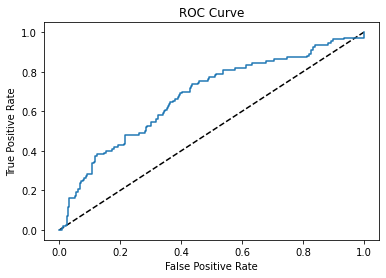

ROC_AUC:  0.6774181818181819


In [86]:
df_credit_without_sex = df_credit.copy()
del df_credit_without_sex['Sex']
get_training_result(df_credit_without_sex, False)

## Age

Accuracy:  0.6984375


Confusion matrix: 
[[177  73]
 [ 48  62]]


              precision    recall  f1-score   support

           0       0.79      0.71      0.75       250
           1       0.46      0.56      0.51       110

    accuracy                           0.66       360
   macro avg       0.62      0.64      0.63       360
weighted avg       0.69      0.66      0.67       360



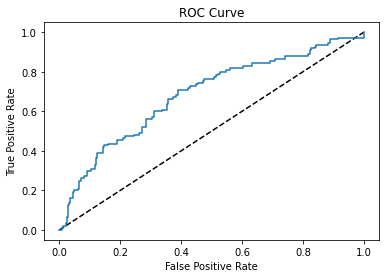

ROC_AUC:  0.6842181818181817


In [87]:
df_credit_without_age = df_credit.copy()
del df_credit_without_age['Age']
get_training_result(df_credit_without_age, False)

# Group fairness and separation with FPR

## Sex

Accuracy:  0.42424242424242425


Confusion matrix: 
[[10 58]
 [ 4 40]]


              precision    recall  f1-score   support

           0       0.71      0.15      0.24        68
           1       0.41      0.91      0.56        44

    accuracy                           0.45       112
   macro avg       0.56      0.53      0.40       112
weighted avg       0.59      0.45      0.37       112



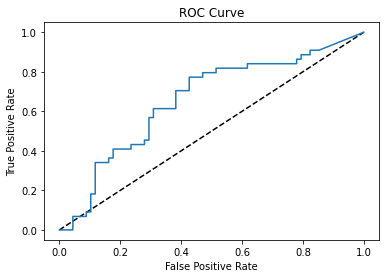

ROC_AUC:  0.6570855614973262


Group fairness:  0.875
Separation with FPR:  0.8529411764705882


In [88]:
# female
df_credit_female = df_credit[df_credit["Sex"] == 0]
get_training_result(df_credit_female)

Accuracy:  0.6870748299319728


Confusion matrix: 
[[128  60]
 [ 23  38]]


              precision    recall  f1-score   support

           0       0.85      0.68      0.76       188
           1       0.39      0.62      0.48        61

    accuracy                           0.67       249
   macro avg       0.62      0.65      0.62       249
weighted avg       0.74      0.67      0.69       249



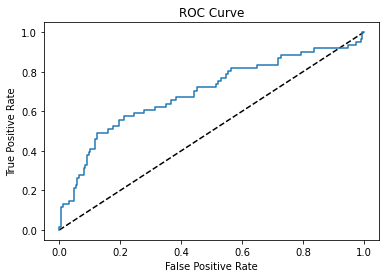

ROC_AUC:  0.6951517265434252


Group fairness:  0.39357429718875503
Separation with FPR:  0.3191489361702128


In [74]:
# male
df_credit_male = df_credit[df_credit["Sex"] == 1]
get_training_result(df_credit_male)

## Age

Accuracy:  0.49586776859504134


Confusion matrix: 
[[ 6 30]
 [ 1 32]]


              precision    recall  f1-score   support

           0       0.86      0.17      0.28        36
           1       0.52      0.97      0.67        33

    accuracy                           0.55        69
   macro avg       0.69      0.57      0.48        69
weighted avg       0.69      0.55      0.47        69



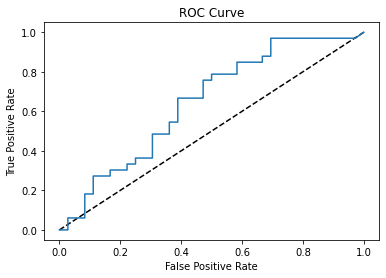

ROC_AUC:  0.6460437710437711


Group fairness:  0.8985507246376812
Separation with FPR:  0.8333333333333334


In [89]:
# student

df_credit_student = df_credit[df_credit["Age_cat"] == 1]
get_training_result(df_credit_student)

Accuracy:  0.38188976377952755


Confusion matrix: 
[[13 88]
 [ 7 36]]


              precision    recall  f1-score   support

           0       0.65      0.13      0.21       101
           1       0.29      0.84      0.43        43

    accuracy                           0.34       144
   macro avg       0.47      0.48      0.32       144
weighted avg       0.54      0.34      0.28       144



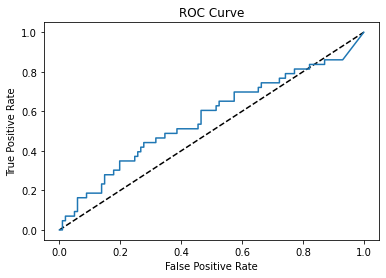

ROC_AUC:  0.5655077135620539


Group fairness:  0.8611111111111112
Separation with FPR:  0.8712871287128713


In [90]:
# young

df_credit_young = df_credit[df_credit["Age_cat"] == 2]
get_training_result(df_credit_young)

Accuracy:  0.782051282051282


Confusion matrix: 
[[75 13]
 [21 24]]


              precision    recall  f1-score   support

           0       0.78      0.85      0.82        88
           1       0.65      0.53      0.59        45

    accuracy                           0.74       133
   macro avg       0.71      0.69      0.70       133
weighted avg       0.74      0.74      0.74       133



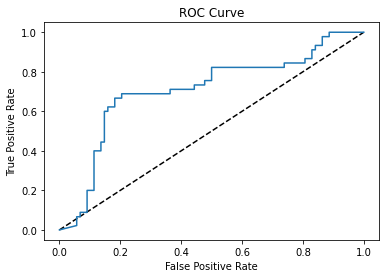

ROC_AUC:  0.707449494949495


Group fairness:  0.2781954887218045
Separation with FPR:  0.14772727272727273


In [91]:
# adult

df_credit_adult = df_credit[df_credit["Age_cat"] == 3]
get_training_result(df_credit_adult)

Accuracy:  0.42857142857142855


Confusion matrix: 
[[ 4 10]
 [ 1  2]]


              precision    recall  f1-score   support

           0       0.80      0.29      0.42        14
           1       0.17      0.67      0.27         3

    accuracy                           0.35        17
   macro avg       0.48      0.48      0.34        17
weighted avg       0.69      0.35      0.39        17



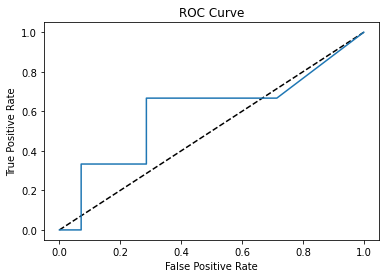

ROC_AUC:  0.5952380952380951


Group fairness:  0.7058823529411765
Separation with FPR:  0.7142857142857143


In [92]:
# senior

df_credit_senior = df_credit[df_credit["Age_cat"] == 4]
get_training_result(df_credit_senior)